In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

In [16]:
# Set dataset path
dataset_path = "C:/Users/HYUN/Downloads/machine learning a2/dataset"

# Collect image file paths and labels based on folder structure
class_names = os.listdir(dataset_path)
all_data = []

for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for img in os.listdir(class_dir):
        all_data.append((os.path.join(class_dir, img), class_name))

# Separate image paths and labels
filepaths, labels = zip(*all_data)

# Split the dataset into 80% training and 20% test sets
train_files, test_files, train_labels, test_labels = train_test_split(filepaths, labels, test_size=0.2, stratify=labels, random_state=42)

# Further split training data into 85% training and 15% validation sets
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.15, stratify=train_labels, random_state=42)


In [17]:
# Data augmentation and preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values to [0,1]
    rotation_range=10,  # Randomly rotate images by 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10%
    height_shift_range=0.1,  # Shift images vertically by 10%
    horizontal_flip=True  # Randomly flip images horizontally
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize validation images
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize test images


In [18]:
# Prepare data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": train_files, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(227, 227),  # Resize images to 227x227
    batch_size=32,
    class_mode="categorical"  # Multi-class classification
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": val_files, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(227, 227),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": test_files, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(227, 227),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # No shuffling to ensure prediction-order alignment
)


Found 2104 validated image filenames belonging to 4 classes.
Found 372 validated image filenames belonging to 4 classes.
Found 620 validated image filenames belonging to 4 classes.


In [19]:
# Load VGG16 model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# Create a new model by adding custom layers on top of VGG16
model = Sequential()
model.add(base_model)  # Add pre-trained VGG16 model
model.add(Flatten())  # Flatten the 3D output to 1D
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Add fully connected layer with L2 regularization
model.add(BatchNormalization())  # Normalize activations to prevent overfitting
model.add(Dropout(0.6))  # Dropout to prevent overfitting
model.add(Dense(4, activation='softmax'))  # Output layer for 4 classes


In [20]:
# Fine-tune the last few layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
    layer.trainable = False


In [36]:
# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',  # Multi-class classification loss
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                      

In [22]:
# Set up learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/20
66/66 [==============================] - 65s 988ms/step - loss: 6.5490 - accuracy: 0.4335 - val_loss: 6.0882 - val_accuracy: 0.3710 - lr: 1.0000e-05
Epoch 2/20
66/66 [==============================] - 58s 881ms/step - loss: 5.8611 - accuracy: 0.6041 - val_loss: 5.5936 - val_accuracy: 0.5941 - lr: 1.0000e-05
Epoch 3/20
66/66 [==============================] - 63s 949ms/step - loss: 5.5063 - accuracy: 0.6592 - val_loss: 5.1943 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 4/20
66/66 [==============================] - 69s 1s/step - loss: 5.2161 - accuracy: 0.7153 - val_loss: 4.9436 - val_accuracy: 0.7849 - lr: 1.0000e-05
Epoch 5/20
66/66 [==============================] - 68s 1s/step - loss: 5.0242 - accuracy: 0.7414 - val_loss: 4.7934 - val_accuracy: 0.8065 - lr: 1.0000e-05
Epoch 6/20
66/66 [==============================] - 71s 1s/step - loss: 4.7942 - accuracy: 0.7676 - val_loss: 4.6064 - val_accuracy: 0.8253 - lr: 1.0000e-05
Epoch 7/20
66/66 [==============================]

In [23]:
# Save the trained model to a file
model.save("tumor_detection_modelv7.h5")


In [24]:
# Evaluate the model on the independent test data
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


20/20 [==============================] - 16s 806ms/step - loss: 3.4699 - accuracy: 0.8984
Test Accuracy: 89.84%


In [25]:
# Extract predicted values and true labels
y_true = test_generator.classes  # True class labels
y_pred = model.predict(test_generator)  # Predicted probabilities
y_pred_classes = tf.argmax(y_pred, axis=1)  # Convert predictions to class indices

# Calculate precision, recall, and F1 score (optional, add as needed)


20/20 [==============================] - 16s 829ms/step


In [26]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Precision: 89.88%
Recall: 89.84%
F1 Score: 89.74%


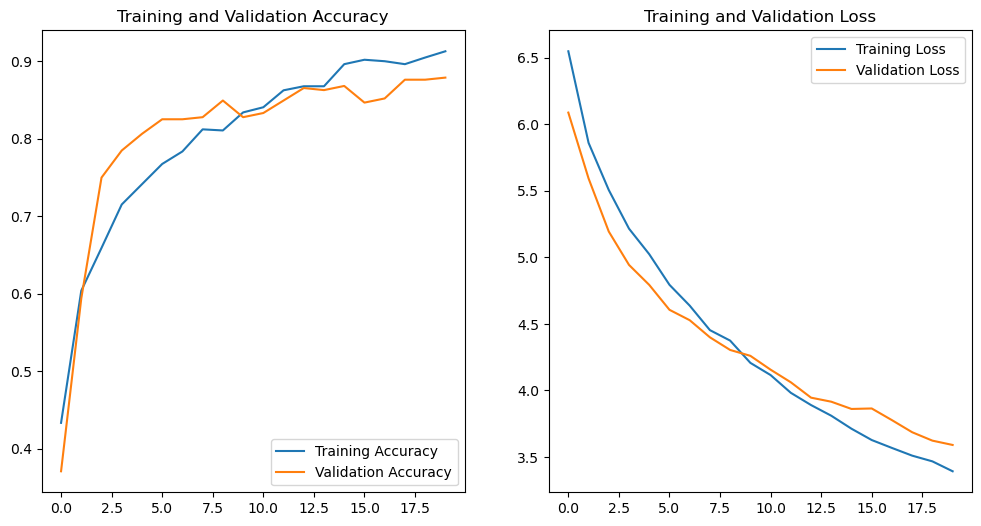

In [27]:
# Visualize training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

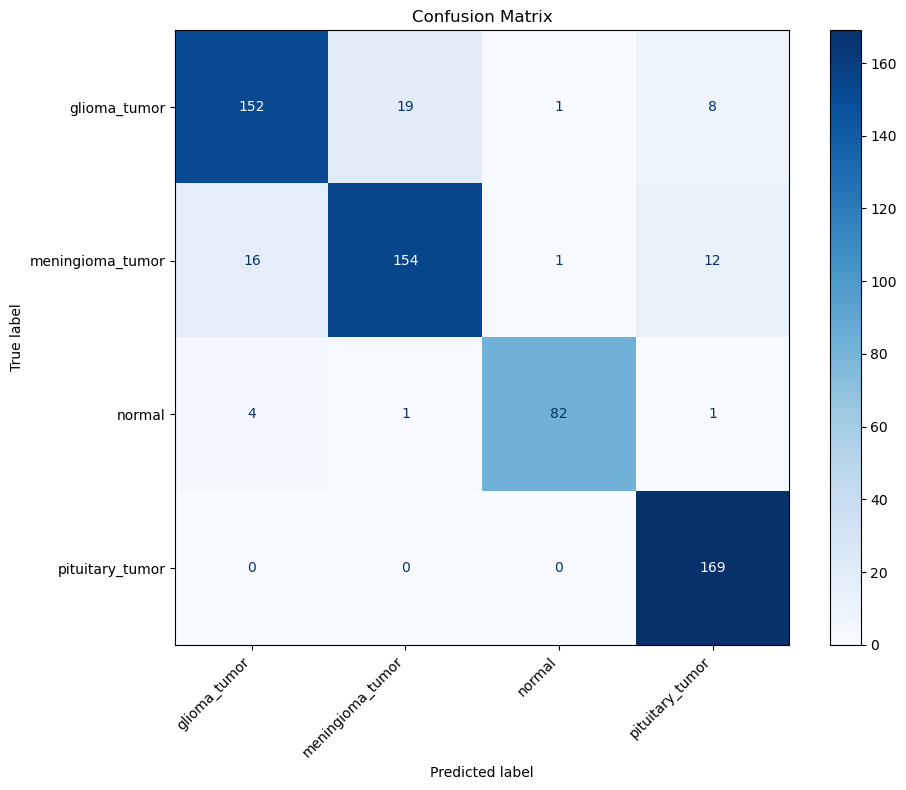

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

# Create a larger plot to avoid label overlap
fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()